In [264]:
import pandas as pd
import joblib 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Bitcoin Price Feature Engineering

In [265]:
# ==========================================
# 1. INDICATORS & FEATURES 
# ==========================================
def calculate_basic_indicators(df):
    data = df.copy()
    data['ema_50'] = data['close'].ewm(span=50, adjust=False).mean()
    data['ema_200'] = data['close'].ewm(span=200, adjust=False).mean()
    
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/14, min_periods=14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/14, min_periods=14, adjust=False).mean()
    rs = gain / loss
    data['rsi_14'] = 100 - (100 / (1 + rs))
    
    if 'volume_usd' not in data.columns:
        data['volume_usd'] = data['close'] * data['volume']
    data['vol_ma20'] = data['volume_usd'].rolling(window=20).mean()
    return data

def calculate_smart_money_features(df):
    df_smc = df.copy()
    
    # ==========================================
    # 1. SETUP: Candle Anatomy
    # ==========================================
    
    # Body size (Absolute value)
    body_size = np.abs(df_smc['close'] - df_smc['open'])
    
    # Total range (High - Low)
    candle_range = df_smc['high'] - df_smc['low']
    
    # Upper and Lower Wicks
    # Upper Wick = High - Max(Open, Close)
    upper_wick = df_smc['high'] - df_smc[['open', 'close']].max(axis=1)
    # Lower Wick = Min(Open, Close) - Low
    lower_wick = df_smc[['open', 'close']].min(axis=1) - df_smc['low']
    
    # Calculate Shock Volume
    # Volume > 2x average of last 20 candles
    avg_vol = df_smc['volume'].rolling(window=20).mean()
    is_shock_vol = df_smc['volume'] > (2 * avg_vol)
    
    # ==========================================
    # 2. ORDER BLOCKS 
    # ==========================================
    
    # Bullish Pinbar, potential demand zone
    df_smc['is_bullish_ob'] = (
        (lower_wick > 2 * body_size) & # Long tail 
        (lower_wick > upper_wick) & # Tail is longer than nose
        (is_shock_vol) # Whales are active
    )
    
    # Bearish Pinbar, potential supply zone
    df_smc['is_bearish_ob'] = (
        (upper_wick > 2 * body_size) & # Long nose
        (upper_wick > lower_wick) &  # Nose is longer than tail
        (is_shock_vol) # Whales are active
    )
    
    # ==========================================
    # 3. FAIR VALUE GAPS (FVG) 
    # ==========================================
    
    
    prev_high = df_smc['high'].shift(2)
    prev_low = df_smc['low'].shift(2)
    
    threshold = df_smc['close'] * 0.0005
    
    
    bullish_gap_size = df_smc['low'] - prev_high
    
    # Bullish FVG: Low > Prev High
    df_smc['is_fvg_bullish'] = (
        (df_smc['low'] > prev_high) & # The Gap exists
        (bullish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] > df_smc['open']) # Current candle is green
    )
    
    bearish_gap_size = prev_low - df_smc['high']
    
    # Bearish FVG: High < Prev Low
    df_smc['is_fvg_bearish'] = (
        (df_smc['high'] < prev_low) & # The Gap exists
        (bearish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] < df_smc['open']) # Current candle is Red
    )
    
    # Clean up, fill NaNs with False
    
    cols_to_fill = ['is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']
    df_smc[cols_to_fill] = df_smc[cols_to_fill].fillna(False)
    
    return df_smc

def create_wyckoff_features(df):
    df_w = df.copy()
    
    df_w['trend_maturity'] = (df_w['ema_50'] - df_w['ema_200']) / df_w['close'] * 100
    df_w['trend_tactical'] = (df_w['close'] - df_w['ema_50']) / df_w['ema_50'] * 100
    
    # Efficiency
    epsilon = 1e-9
    range_len = df_w['high'] - df_w['low'] 
    body_len = abs(df_w['close'] - df_w['open'])
    df_w['efficiency_regime'] = (body_len / (range_len + epsilon)).rolling(window=20).mean()
    
    # Volume Regime
    df_w['rel_volume'] = df_w['volume_usd'] / df_w['vol_ma20']
    df_w['vol_regime'] = df_w['rel_volume'].rolling(window=1).mean()
    
    # Structure Score
    structure_score = np.zeros(len(df_w))
    current_score = 0 
    decay = 0.98
    
    bull_ob = df_w['is_bullish_ob'].values.astype(int)
    bear_ob = df_w['is_bearish_ob'].values.astype(int)
    fvg_bull = df_w['is_fvg_bullish'].values.astype(int)
    fvg_bear = df_w['is_fvg_bearish'].values.astype(int)
    
    for i in range(1, len(df_w)):
        current_score *= decay
        if bull_ob[i]: current_score += 1.0
        if bear_ob[i]: current_score -= 1.0 
        if fvg_bull[i]: current_score += 0.5
        if fvg_bear[i]: current_score -= 0.5
        structure_score[i] = current_score
        
    df_w['structure_score'] = structure_score
    return df_w

# --- 2. DISCRETIZATION ---
def discretize_features(df, cluster_map):
    data = df.copy()
    
    # Bins
    data['RSI_Bin'] = pd.cut(data['rsi_14'], bins=[-np.inf, 30, 45, 55, 70, np.inf], labels=['RSI_Oversold', 'RSI_Bearish', 'RSI_Neutral', 'RSI_Bullish', 'RSI_Overbought'])
    data['Vol_Bin'] = pd.cut(data['vol_regime'], bins=[-np.inf, 0.5, 1.5, 3.0, np.inf], labels=['Vol_Low', 'Vol_Normal', 'Vol_High', 'Vol_Shock'])
    data['Trend_Bin'] = pd.cut(data['trend_tactical'], bins=[-np.inf, -0.6, -0.1, 0.1, 0.6, np.inf], labels=['Trend_Overextended_Bear', 'Trend_Bearish', 'Trend_Neutral', 'Trend_Bullish', 'Trend_Overextended_Bull'])
    data['Struct_Bin'] = pd.cut(data['structure_score'], bins=[-np.inf, -0.5, 0.5, np.inf], labels=['Struct_Bear', 'Struct_Neutral', 'Struct_Bull'])
    
    # Phase Mapping
    if 'cluster' in data.columns:
        data['Phase_Label'] = data['cluster'].map(cluster_map)
    
    cols = ['open_time', 'close', 'cluster', 'Phase_Label', 'RSI_Bin', 'Vol_Bin', 'Trend_Bin', 'Struct_Bin']
    return data[[c for c in cols if c in data.columns]].dropna()



In [266]:
# Helper: auto-detect labels
def get_dynamic_cluster_map(kmeans_model):
    centers = kmeans_model.cluster_centers_

    # 1. Markup = Highest Trend 
    markup = np.argmax(centers[:, 0]) 

    # 2. Markdown = Lowest Trend
    

In [267]:
def generate_test_transactions(train_path="Data/bitcoin_data_train.csv",
                               test_path="Data/bitcoin_data_test.csv",
                               model_path="Models/kmeans_wyckoff_model.pkl"):
    print("1. Loading Data...")
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    
    # Convert dates 
    df_train['open_time'] = pd.to_datetime(df_train['open_time'])
    df_test['open_time'] = pd.to_datetime(df_test['open_time'])

    # Generate raw features for both sets
    print("2. Generating Raw Features...")
    df_train = calculate_basic_indicators(df_train)
    df_train = calculate_smart_money_features(df_train)
    df_train = create_wyckoff_features(df_train) 
    
    df_test = calculate_basic_indicators(df_test)
    df_test = calculate_smart_money_features(df_test)
    df_test = create_wyckoff_features(df_test)
    
    # Define the exact columns the model expects
    feature_cols = ["trend_tactical", "trend_maturity", "efficiency_regime", "vol_regime", "structure_score"]
    
    # Drop NaNs to ensure alignment
    df_train = df_train.dropna(subset=feature_cols)
    df_test = df_test.dropna(subset=feature_cols)
    
    # Train scaler on history 
    print("3. Fitting Scaler on Training Data...")
    scaler = StandardScaler()
    scaler.fit(df_train[feature_cols]) # Learn Mean and Std from 2023-01-01 to 2024-12-31
    
    # Scale test data
    print("4. Scaling Test Data")
    # use training stats to scale the test data
    X_test_scaled = scaler.transform(df_test[feature_cols])
    
    # Predict 
    print("5. Loading Model and Predicting...")
    kmeans = joblib.load(model_path)
    
    df_test['cluster'] = kmeans.predict(X_test_scaled)

    cluster_map = {
        0: 'Phase_Markup',
        1: 'Phase_Accumulation',
        2: 'Phase_Climax',
        3: 'Phase_Markdown'
    }

    print("6. Discretizing...")
    return discretize_features(df_test, cluster_map)


    

In [268]:
test_transactions = generate_test_transactions()
test_transactions.head()

1. Loading Data...
2. Generating Raw Features...
3. Fitting Scaler on Training Data...
4. Scaling Test Data
5. Loading Model and Predicting...
6. Discretizing...


,open_time,close,cluster,Phase_Label,RSI_Bin,Vol_Bin,Trend_Bin,Struct_Bin
19,2025-01-01 00:19:00,93796.35,0,Phase_Markup,RSI_Bullish,Vol_Normal,Trend_Bullish,Struct_Bull
20,2025-01-01 00:20:00,93866.00,1,Phase_Accumulation,RSI_Overbought,Vol_Normal,Trend_Bullish,Struct_Bull
21,2025-01-01 00:21:00,93800.00,1,Phase_Accumulation,RSI_Bullish,Vol_High,Trend_Bullish,Struct_Neutral
22,2025-01-01 00:22:00,93733.50,1,Phase_Accumulation,RSI_Neutral,Vol_Low,Trend_Neutral,Struct_Neutral
23,2025-01-01 00:23:00,93748.42,1,Phase_Accumulation,RSI_Bullish,Vol_Normal,Trend_Neutral,Struct_Neutral


In [269]:
test_transactions['Phase_Label'].value_counts()

Phase_Label
Phase_Accumulation    239101
Phase_Markdown        121026
Phase_Markup           95244
Phase_Climax           34210
Name: count, dtype: int64

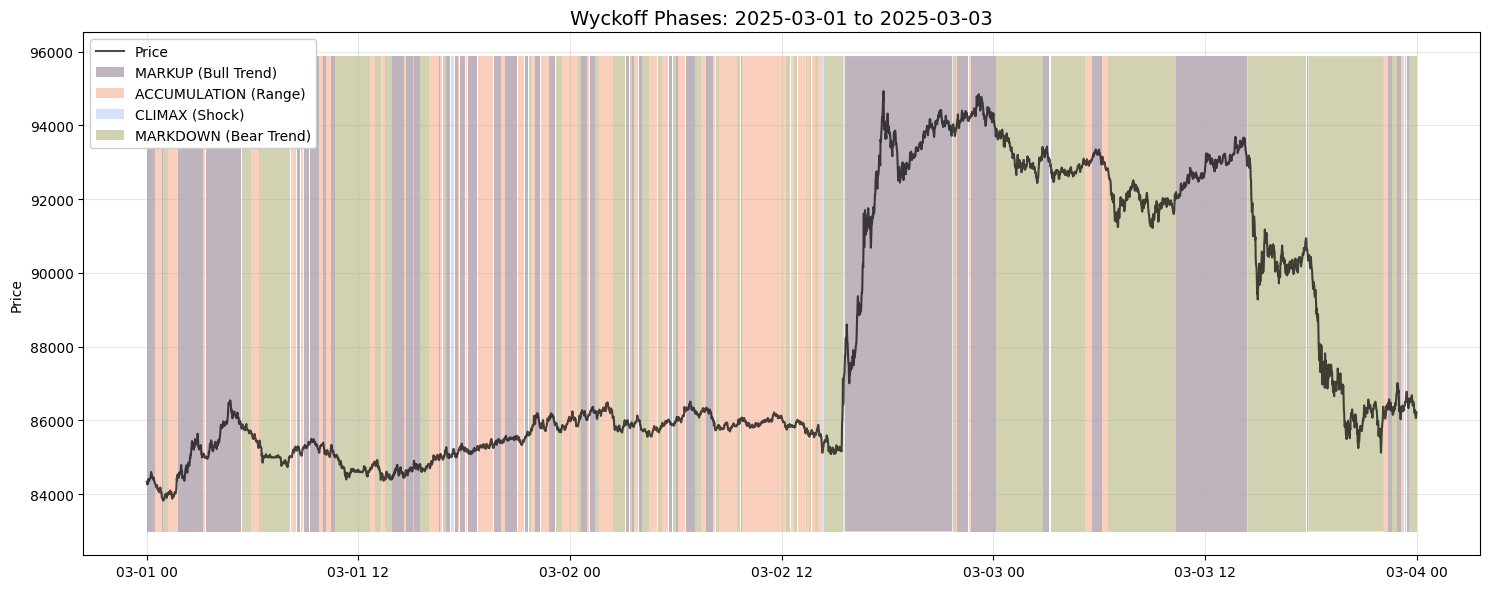

In [270]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_wyckoff_zoom(df_cluster, start_date, end_date, smooth_window=10):
    """
    Plots Price vs Wyckoff Clusters for a specific time interval.
    """
    df = df_cluster.copy()
    if 'open_time' in df.columns:
        df['open_time'] = pd.to_datetime(df['open_time'])
        df.set_index('open_time', inplace=True)

    # 1. Prepare Data Slice
    subset = df.loc[start_date:end_date].copy()
    
    # 2. Apply Smoothing 
    subset['smooth_cluster'] = subset['cluster'].rolling(window=smooth_window).apply(
        lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else x[int(smooth_window/2)], 
        raw=True
    ).fillna(method='bfill')

    # 3. Define Colors 
    colors = {0: "#2b0527", 1: "#f5632a", 2: "#789cf0", 3: "#6d6b03"}
    labels = {0: 'MARKUP (Bull Trend)', 1: 'ACCUMULATION (Range)', 2: 'CLIMAX (Shock)', 3: 'MARKDOWN (Bear Trend)'}

    # 4. Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot Price Line
    ax.plot(subset.index, subset['close'], color='black', linewidth=1.5, alpha=0.7, label='Price')

    # Paint Background (Vectorized)
    for cluster_id, color in colors.items():
        mask = (subset['smooth_cluster'] == cluster_id)
        ax.fill_between(
            subset.index, 
            y1=subset['close'].min() * 0.99, # Dynamic Y-limits for the zoom
            y2=subset['close'].max() * 1.01, 
            where=mask, 
            color=color, alpha=0.3, 
            linewidth=0, step='mid',
            label=labels[cluster_id]
        )

    # Styling
    ax.set_title(f"Wyckoff Phases: {start_date} to {end_date}", fontsize=14)
    ax.set_ylabel("Price")
    ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=1)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



plot_wyckoff_zoom(test_transactions, '2025-03-01', '2025-03-03', smooth_window=10)

## Signal Scoring Engine

In [271]:
def load_trading_rules(rules_path="Data/association_rules_news.csv", min_conf=0.3, min_lift=1.0):
    # Loading rules and separate them into BUY (PUMP) and SELL (DUMP) logic
    print(f"1. Loading Rules from {rules_path}...")
    rules = pd.read_csv(rules_path)

    # Filter Actionable Rules
    actionable = rules[
        (rules['consequents'].astype(str).str.contains('Pump|Dump')) &
        (rules['confidence'] >= min_conf) &
        (rules['lift'] > min_lift)
    ].copy()

    # Preprocess for Speed 
    actionable['itemset'] = actionable['antecedents'].apply(
        lambda x: set(x.replace("'", "").replace("frozenset({", "").replace("})", "").split(', '))
    )

    # Calculate weight of rules
    actionable['power'] = actionable['confidence'] * actionable['lift']

    print(f"Loaded {len(actionable)} actionable trading rules")

 

    return actionable 

def generate_signals(df_transactions, rules_df):
    print("2. Scoring Signals...")
    data = df_transactions.copy()

    feature_cols = [c for c in data.columns if c not in ['open_time', 'close', 'target_label', 'cluster']]

    # Create a list of sets
    records = data[feature_cols].astype(str).values
    transaction_sets = [set(row) for row in records]

    # Prepare Result Array
    bull_scores = np.zeros(len(data))
    bear_scores = np.zeros(len(data))
    
    # rules 
    pump_rules = rules_df[rules_df['consequents'].str.contains('Pump')]
    dump_rules = rules_df[rules_df['consequents'].str.contains("Dump")]

    print(f"Checking {len(data)} candles against {len(pump_rules)} Buy rules and {len(dump_rules)} Sell rules...")


    for i, current_basket in enumerate(tqdm(transaction_sets)):
        # Sum power of all matching BUY rules
        bull_power = sum(r.power for r in pump_rules.itertuples() if r.itemset.issubset(current_basket))

        # Sum power of all matching SELL rules
        bear_power = sum(r.power for r in dump_rules.itertuples() if r.itemset.issubset(current_basket))

        bull_scores[i] = bull_power
        bear_scores[i] = bear_power
    
    data['Bull_Score'] = bull_scores
    data['Bear_Score'] = bear_scores 
    data['Net_Signal'] = bull_scores - bear_scores

    return data

In [272]:
trading_rules = load_trading_rules()

df_scored = generate_signals(test_transactions, trading_rules)
df_scored.head()

1. Loading Rules from Data/association_rules_news.csv...
Loaded 711 actionable trading rules
2. Scoring Signals...
Checking 489581 candles against 350 Buy rules and 361 Sell rules...


100%|██████████| 489581/489581 [16:47<00:00, 485.74it/s]


,open_time,close,cluster,Phase_Label,RSI_Bin,Vol_Bin,Trend_Bin,Struct_Bin,Bull_Score,Bear_Score,Net_Signal
19,2025-01-01 00:19:00,93796.35,0,Phase_Markup,RSI_Bullish,Vol_Normal,Trend_Bullish,Struct_Bull,10.701033,12.591670,-1.890636
20,2025-01-01 00:20:00,93866.00,1,Phase_Accumulation,RSI_Overbought,Vol_Normal,Trend_Bullish,Struct_Bull,2.677469,7.082307,-4.404839
21,2025-01-01 00:21:00,93800.00,1,Phase_Accumulation,RSI_Bullish,Vol_High,Trend_Bullish,Struct_Neutral,2.321660,4.879093,-2.557433
22,2025-01-01 00:22:00,93733.50,1,Phase_Accumulation,RSI_Neutral,Vol_Low,Trend_Neutral,Struct_Neutral,0.666406,1.021930,-0.355524
23,2025-01-01 00:23:00,93748.42,1,Phase_Accumulation,RSI_Bullish,Vol_Normal,Trend_Neutral,Struct_Neutral,1.310480,2.065430,-0.754950


In [273]:
df_scored['Net_Signal'].describe()

count    489581.000000
mean         -0.006753
std           1.687053
min          -4.729095
25%          -1.079308
50%          -0.253161
75%           1.327998
max           4.060433
Name: Net_Signal, dtype: float64

In [274]:
df_scored.to_csv("Data/bitcoin_data_feature_engineered_test.csv")

## News Feature Engineering

### Text Processing & Feature Engineering

In [275]:
import re
import html 

# Text Cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\bRT\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower() # Added lower() to normalize for keywords later


# Reaction aggregation and z-score

def process_news_reaction_features(news_path):
    print("1. Loading News Data...")
    df = pd.read_csv(news_path)
    
    # filter 'currencies' to only Bitcoin related news
    df = df[df['currencies'].str.contains('BTC', na=False)]

    # Drop unnecessary columns
    columns_to_drop = ['id', 'sourceId', 'sourceDomain', 'sourceUrl', 'url']

    if set(columns_to_drop).issubset(df.columns):
        df = df.drop(columns=columns_to_drop)

    # Handle Dates
    if 'newsDatetime' in df.columns:
        df['newsDatetime'] = pd.to_datetime(df['newsDatetime'])
        df = df.set_index('newsDatetime').sort_index()
    else:
        # Fallback if column name differs
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').sort_index()

    # Filter for 2025 Test Period
    df = df[df.index >= '2025-01-01'].copy()
    
    # Clean Text
    df['clean_title'] = df['title'].apply(clean_text)

    print("2. Aggregating Reactions...")
    # Summing columns 
    pos_cols = ['positive', 'liked', 'important', 'saved']
    neg_cols = ['negative', 'disliked', 'toxic', 'lol']
    
    # Fill missing columns with 0
    for c in pos_cols + neg_cols + ['comments']:
        if c not in df.columns: df[c] = 0
            
    df['Reaction_Positive'] = df[pos_cols].sum(axis=1)
    df['Reaction_Negative'] = df[neg_cols].sum(axis=1)
    df['Total_Reactions'] = df['Reaction_Positive'] + df['Reaction_Negative'] + df['comments']

    print("3. Calculating Rolling Z-Scores (24h Window)...")
    window = '24h'
    
    # Positive Z
    pos_mean = df['Reaction_Positive'].rolling(window).mean()
    pos_std = df['Reaction_Positive'].rolling(window).std().replace(0, 1)
    df['Z_Pos'] = (df['Reaction_Positive'] - pos_mean) / pos_std
    
    # Negative Z
    neg_mean = df['Reaction_Negative'].rolling(window).mean()
    neg_std = df['Reaction_Negative'].rolling(window).std().replace(0, 1)
    df['Z_Neg'] = (df['Reaction_Negative'] - neg_mean) / neg_std
    
    # Net Sentiment Z-Score
    df['Sentiment_Z_Score'] = df['Z_Pos'] - df['Z_Neg']
    
    # Volume Z-Score (Buzz)
    vol_mean = df['Total_Reactions'].rolling(window).mean()
    vol_std = df['Total_Reactions'].rolling(window).std().replace(0, 1)
    df['Volume_Z_Score'] = (df['Total_Reactions'] - vol_mean) / vol_std
    
    # Hard Neutral Reset (No Volume = No Sentiment)
    df.loc[df['Total_Reactions'] == 0, 'Sentiment_Z_Score'] = 0
    df = df.fillna(0)

    print("4. Discretizing to Match Rules...")
    # Map to the labels your Association Rules expect (Sent_Positive, etc.)
    
    # Sentiment Bins
    sent_bins = [-np.inf, -0.5, 0.5, np.inf]
    sent_labels = ['Sent_Negative', 'Sent_Neutral', 'Sent_Positive']
    df['News_Sentiment'] = pd.cut(df['Sentiment_Z_Score'], bins=sent_bins, labels=sent_labels)
    
    # Buzz Bins
    vol_bins = [-np.inf, -0.5, 2, np.inf]
    vol_labels = ['Buzz_Low', 'Buzz_Medium', 'Buzz_High'] 
    df['News_Buzz'] = pd.cut(df['Volume_Z_Score'], bins=vol_bins, labels=vol_labels)
    
    return df.reset_index()


In [276]:
df_news_test = process_news_reaction_features("Data/news.csv")

1. Loading News Data...
2. Aggregating Reactions...
3. Calculating Rolling Z-Scores (24h Window)...
4. Discretizing to Match Rules...


In [277]:
print(f"Length of News Data: {len(df_news_test)}")
df_news_test.head(2)

Length of News Data: 8423


,newsDatetime,title,description,negative,positive,important,liked,disliked,lol,toxic,...,clean_title,Reaction_Positive,Reaction_Negative,Total_Reactions,Z_Pos,Z_Neg,Sentiment_Z_Score,Volume_Z_Score,News_Sentiment,News_Buzz
0,2025-01-01 00:01:00,Bitcoin (BTC) Loses Support: 2025 to Begin Wit...,0,0,0,0,0,0,0,0,...,bitcoin (btc) loses support: 2025 to begin wit...,0,0,0,0.0,0.0,0.0,0.0,Sent_Neutral,Buzz_Medium
1,2025-01-01 03:43:37,Bitcoin Spot ETF Sees Significant Inflow,0,0,0,0,0,0,0,0,...,bitcoin spot etf sees significant inflow,0,0,0,0.0,0.0,0.0,0.0,Sent_Neutral,Buzz_Medium


### Topic Classification

In [278]:
import json 

def assign_topic(df, json_path="Models/topic_keywords.json"):
    print(f"5. Classifying Topics using {json_path}...")

    data = df.copy()

    # Load the keywords from the JSON file
    with open(json_path, "r") as f: 
        raw_map = json.load(f)

    # convert keys to int 
    topic_keywords = {int(k): set(v) for k, v in raw_map.items()}

    # label map 
    label_map = {
        0: "Topic_Exchange_DeFi",
        1: "Topic_Market_Stats",
        2: "Topic_Altcoins_Memes",
        3: "Topic_Macro_Politics",
        4: "Topic_Price_Prediction"
    }

    def classify_overlap(text):
        if not isinstance(text, str): return "Topic_None"

        words = set(text.lower().split())

        best_topic = None 
        max_overlap = 0

        # Check overlap with each topic's keyword set 
        for topic_id, keywords in topic_keywords.items():
            # count how many words in the headline exist in this topic's keyword
            overlap = len(words.intersection(keywords))

            if overlap > max_overlap:
                max_overlap = overlap
                best_topic = topic_id 

        # If no overlap found, default to General 
        if best_topic is None: 
            return 'Topic_None'
    
        return label_map.get(best_topic, f"Topic_{best_topic}")
    
    data['News_Topic'] = data['clean_title'].apply(classify_overlap)

    return data 


        


In [279]:
import json

def assign_topic(df, json_path='Models/topic_keywords.json'):
    print(f"3. Classifying Topics using {json_path}...")
    data = df.copy()
    
    # 1. Load from File
    with open(json_path, 'r') as f:
        raw_map = json.load(f)
    
    # Convert to Sets for Speed (JSON keys are always strings "0", "1")
    topic_keywords = {int(k): set(v) for k, v in raw_map.items()}
    
    # Map IDs to Names
    label_map = {
        0: 'Topic_Exchange_DeFi',
        1: 'Topic_Market_Stats',
        2: 'Topic_Altcoins_Memes',
        3: 'Topic_Macro_Politics',
        4: 'Topic_Price_Prediction'
    }

    def classify(text):
        if not isinstance(text, str): return 'Topic_None'
        words = set(text.lower().split())
        
        best_topic = None
        max_overlap = 0
        
        for topic_id, key_list in topic_keywords.items():
            overlap = len(words.intersection(key_list))
            
            if overlap > max_overlap:
                max_overlap = overlap
                best_topic = topic_id
            elif overlap == max_overlap and overlap > 0:
        
                if topic_id in [4, 2]: 
                    best_topic = topic_id
        
        if best_topic is None: return 'Topic_None'
        return label_map.get(best_topic, 'Topic_None')

    data['News_Topic'] = data['clean_title'].apply(classify)
    return data

In [280]:
df_news_test = assign_topic(df_news_test)
df_news_test.head(5)

3. Classifying Topics using Models/topic_keywords.json...


,newsDatetime,title,description,negative,positive,important,liked,disliked,lol,toxic,...,Reaction_Positive,Reaction_Negative,Total_Reactions,Z_Pos,Z_Neg,Sentiment_Z_Score,Volume_Z_Score,News_Sentiment,News_Buzz,News_Topic
0,2025-01-01 00:01:00,Bitcoin (BTC) Loses Support: 2025 to Begin Wit...,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,Sent_Neutral,Buzz_Medium,Topic_Exchange_DeFi
1,2025-01-01 03:43:37,Bitcoin Spot ETF Sees Significant Inflow,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,Sent_Neutral,Buzz_Medium,Topic_Price_Prediction
2,2025-01-01 05:59:11,Hive Digital moves HQ to Texas citing supporti...,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,Sent_Neutral,Buzz_Medium,Topic_Price_Prediction
3,2025-01-01 06:36:41,Bitcoin’s Rally Propels Coinbase and Robinhood...,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,Sent_Neutral,Buzz_Medium,Topic_Price_Prediction
4,2025-01-01 07:30:00,3 Altcoins That Reached All-Time Highs Today —...,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,Sent_Neutral,Buzz_Medium,Topic_Altcoins_Memes


In [281]:
df_news_test['News_Topic'].value_counts()

News_Topic
Topic_Price_Prediction    3795
Topic_Altcoins_Memes      1557
Topic_Market_Stats        1123
Topic_Exchange_DeFi       1033
Topic_Macro_Politics       839
Topic_None                  76
Name: count, dtype: int64

### Merge News and Price data

In [282]:
def integrate_data_test(scored_df, news_df):
    print("--- 1. PREPARING NEWS DATA (Hourly Aggregation) ---")
    df_news = news_df.copy()

    # 1. Handle Dates
    date_col = 'newsDatetime' if 'newsDatetime' in df_news.columns else 'date'
    df_news[date_col] = pd.to_datetime(df_news[date_col], errors='coerce')
    df_news = df_news.set_index(date_col).sort_index()


    # 2. Hourly Aggregation
    hourly_news = df_news.resample('1h').agg({
        'Sentiment_Z_Score': 'mean',
        'Volume_Z_Score': 'mean',
        'News_Topic': lambda x: x.mode()[0] if not x.mode().empty else "Topic_None"
    })

    # shift by 1 hour to avoid lookahead bias
    hourly_news = hourly_news.shift(1)

    # Sentiment bins 
    conditions_sent = [
        hourly_news['Sentiment_Z_Score'] > 0.5,
        hourly_news['Sentiment_Z_Score'] < -0.5
    ]

    # Buzz bins
    condition_buzz = [
        hourly_news['Volume_Z_Score'] > 2,
        hourly_news['Volume_Z_Score'] < -0.5
    ]


    hourly_news['News_Sentiment'] = np.select(conditions_sent, ['Sent_Positive', 'Sent_Negative'], default='Sent_Neutral')
    hourly_news['News_Buzz'] = np.select(condition_buzz, ['Buzz_High', 'Buzz_Low'], default='Buzz_Normal')

    # Fill N/A for Topic
    hourly_news['News_Topic'] = hourly_news['News_Topic'].fillna('Topic_None')

    print("--- 2. INTEGRATING WITH TRANSACTION DATA ---")

    df_main = scored_df.copy()
    df_main['open_time'] = pd.to_datetime(df_main['open_time'])
    df_main = df_main.set_index('open_time').sort_index()

    # Merge on index (open_time)
    merged_df = pd.merge_asof(
        df_main, 
        hourly_news[['News_Sentiment', "News_Buzz", "News_Topic"]],
        left_index=True,
        right_index=True,
        direction='backward'
    )

    # Fill N/A values
    merged_df['News_Sentiment'] = merged_df['News_Sentiment'].fillna('Sent_Neutral')
    merged_df['News_Buzz'] = merged_df['News_Buzz'].fillna('Buzz_Normal')
    merged_df['News_Topic'] = merged_df['News_Topic'].fillna('Topic_None')

    print(f"   -> Merged Shape: {merged_df.shape}")

    return merged_df 



    

In [283]:
integrated_df = integrate_data_test(test_transactions, df_news_test)
integrated_df.head()

--- 1. PREPARING NEWS DATA (Hourly Aggregation) ---
--- 2. INTEGRATING WITH TRANSACTION DATA ---
   -> Merged Shape: (489581, 10)


,close,cluster,Phase_Label,RSI_Bin,Vol_Bin,Trend_Bin,Struct_Bin,News_Sentiment,News_Buzz,News_Topic
open_time,,,,,,,,,,
2025-01-01 00:19:00,93796.35,0,Phase_Markup,RSI_Bullish,Vol_Normal,Trend_Bullish,Struct_Bull,Sent_Neutral,Buzz_Normal,Topic_None
2025-01-01 00:20:00,93866.00,1,Phase_Accumulation,RSI_Overbought,Vol_Normal,Trend_Bullish,Struct_Bull,Sent_Neutral,Buzz_Normal,Topic_None
2025-01-01 00:21:00,93800.00,1,Phase_Accumulation,RSI_Bullish,Vol_High,Trend_Bullish,Struct_Neutral,Sent_Neutral,Buzz_Normal,Topic_None
2025-01-01 00:22:00,93733.50,1,Phase_Accumulation,RSI_Neutral,Vol_Low,Trend_Neutral,Struct_Neutral,Sent_Neutral,Buzz_Normal,Topic_None
2025-01-01 00:23:00,93748.42,1,Phase_Accumulation,RSI_Bullish,Vol_Normal,Trend_Neutral,Struct_Neutral,Sent_Neutral,Buzz_Normal,Topic_None


### RE-Score with News Extracted Features

In [284]:
integrated_df = generate_signals(integrated_df, trading_rules)

2. Scoring Signals...
Checking 489581 candles against 350 Buy rules and 361 Sell rules...


100%|██████████| 489581/489581 [16:30<00:00, 494.23it/s]


In [285]:
integrated_df.head()

,close,cluster,Phase_Label,RSI_Bin,Vol_Bin,Trend_Bin,Struct_Bin,News_Sentiment,News_Buzz,News_Topic,Bull_Score,Bear_Score,Net_Signal
open_time,,,,,,,,,,,,,
2025-01-01 00:19:00,93796.35,0,Phase_Markup,RSI_Bullish,Vol_Normal,Trend_Bullish,Struct_Bull,Sent_Neutral,Buzz_Normal,Topic_None,10.701033,12.591670,-1.890636
2025-01-01 00:20:00,93866.00,1,Phase_Accumulation,RSI_Overbought,Vol_Normal,Trend_Bullish,Struct_Bull,Sent_Neutral,Buzz_Normal,Topic_None,2.677469,7.082307,-4.404839
2025-01-01 00:21:00,93800.00,1,Phase_Accumulation,RSI_Bullish,Vol_High,Trend_Bullish,Struct_Neutral,Sent_Neutral,Buzz_Normal,Topic_None,2.321660,4.879093,-2.557433
2025-01-01 00:22:00,93733.50,1,Phase_Accumulation,RSI_Neutral,Vol_Low,Trend_Neutral,Struct_Neutral,Sent_Neutral,Buzz_Normal,Topic_None,0.666406,1.021930,-0.355524
2025-01-01 00:23:00,93748.42,1,Phase_Accumulation,RSI_Bullish,Vol_Normal,Trend_Neutral,Struct_Neutral,Sent_Neutral,Buzz_Normal,Topic_None,1.310480,2.065430,-0.754950


In [286]:
integrated_df.to_csv("Data/bitcoin_data_integrated_test.csv")

## Backtesting Models

### Descriptive Statistics to Assess Data Health

In [287]:
import seaborn as sns

def analyze_data_health(df):
    print("--- 1. DATA INTEGRITY CHECK ---")
    print(f"Total Rows: {len(df)}")
    
    # Check for NaNs
    nan_counts = df.isnull().sum()
    if nan_counts.sum() > 0:
        print("\n⚠️ WARNING: Missing Values Detected:")
        print(nan_counts[nan_counts > 0])
    else:
        print("✅ No Missing Values found.")

    # --- 2. NUMERICAL DISTRIBUTION (Scores & Price) ---
    numeric_cols = ['close', 'Bull_Score', 'Bear_Score', 'Net_Signal']
    # Filter only existing columns
    numeric_cols = [c for c in numeric_cols if c in df.columns]
    
    print("\n--- 2. NUMERICAL STATISTICS ---")
    print(df[numeric_cols].describe().round(4))
    
    # Visualization: Score Distributions
    plt.figure(figsize=(15, 5))
    
    # Plot Net Signal Distribution
    if 'Net_Signal' in df.columns:
        plt.subplot(1, 3, 1)
        sns.histplot(df['Net_Signal'], bins=50, kde=True, color='purple')
        plt.title('Net Signal Distribution')
        plt.axvline(0.5, color='green', linestyle='--', label='Buy Threshold')
        plt.axvline(-0.5, color='red', linestyle='--', label='Sell Threshold')
        plt.legend()
        
    # Plot Bull vs Bear Scores
    if 'Bull_Score' in df.columns and 'Bear_Score' in df.columns:
        plt.subplot(1, 3, 2)
        
        # Plot Bull Scores (Green)
        sns.histplot(df['Bull_Score'], bins=30, color='green', alpha=0.3, 
                     label='Bull Score', kde=True, element="step")
        
        # Plot Bear Scores (Red)
        sns.histplot(df['Bear_Score'], bins=30, color='red', alpha=0.3, 
                     label='Bear Score', kde=True, element="step")
        
        # Add Vertical Lines for the Means
        bull_mean = df['Bull_Score'].mean()
        bear_mean = df['Bear_Score'].mean()
        
        plt.axvline(bull_mean, color='darkgreen', linestyle='--', linewidth=2, 
                    label=f'Avg Bull: {bull_mean:.2f}')
        plt.axvline(bear_mean, color='darkred', linestyle='--', linewidth=2, 
                    label=f'Avg Bear: {bear_mean:.2f}')
        
        plt.title('Bull vs Bear Power Distribution')
        plt.xlabel('Score Value')
        plt.ylabel('Frequency (Candles)')
        plt.legend()
        
    # Plot Price
    plt.subplot(1, 3, 3)
    plt.plot(df['close'], color='black', alpha=0.7)
    plt.title('Price Action')
    
    plt.tight_layout()
    plt.show()

    # --- 3. CATEGORICAL BALANCE (Features) ---
    cat_cols = [
        'Phase_Label', 'News_Topic', 'News_Sentiment', 
        'RSI_Bin', 'Vol_Bin', 'Trend_Bin'
    ]
    # Filter existing
    cat_cols = [c for c in cat_cols if c in df.columns]
    
    plt.figure(figsize=(20, 10))
    for i, col in enumerate(cat_cols, 1):
        plt.subplot(2, 3, i)
        
        # Calculate counts and percentages
        counts = df[col].value_counts(normalize=True).sort_index()
        
        # Plot
        sns.barplot(x=counts.index, y=counts.values, palette='viridis')
        plt.title(f'{col} Distribution')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Percentage')
        
        # Add labels
        for j, v in enumerate(counts.values):
            plt.text(j, v, f"{v:.1%}", ha='center', va='bottom', fontsize=9)
            
    plt.tight_layout()
    plt.show()



Data Health Analysis for Integrated Test Set:
--- 1. DATA INTEGRITY CHECK ---
Total Rows: 489581
✅ No Missing Values found.

--- 2. NUMERICAL STATISTICS ---
             close   Bull_Score   Bear_Score   Net_Signal
count  489581.0000  489581.0000  489581.0000  489581.0000
mean   102579.4476       5.6978       5.7787      -0.0809
std     11567.2480       3.9778       4.1729       2.0374
min     74610.0000       0.0000       0.0000      -7.8736
25%     94240.4800       2.2891       2.3291      -1.4505
50%    104520.2800       5.0464       4.9041      -0.2668
75%    111559.9900       8.4874       8.9331       1.3539
max    126114.5000      18.5280      19.7686       6.6143


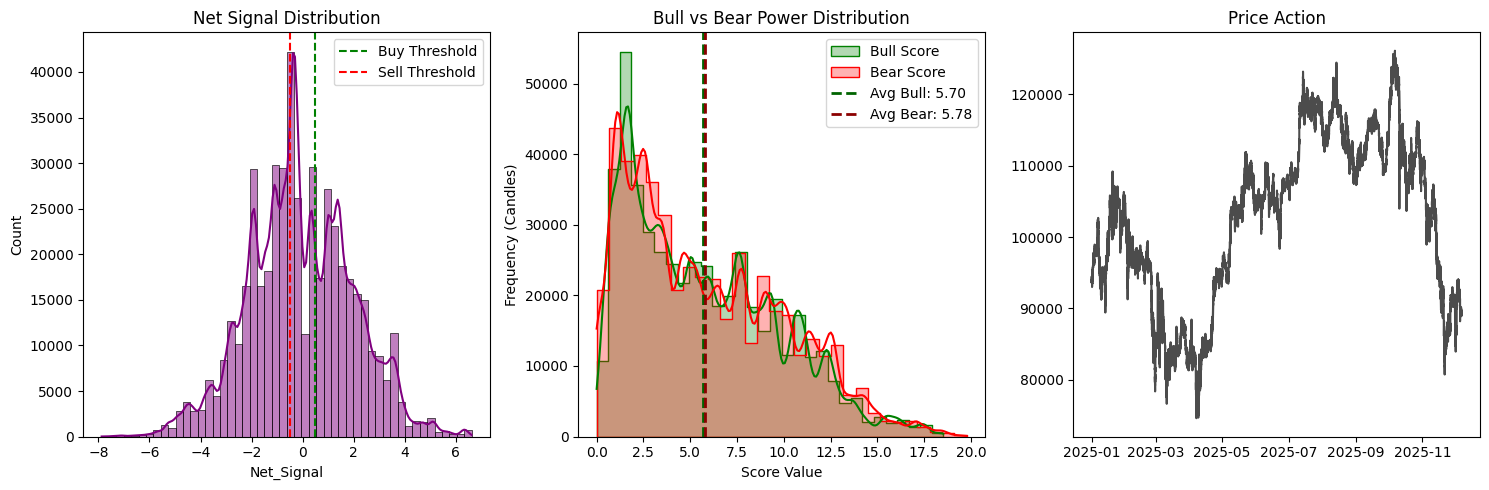

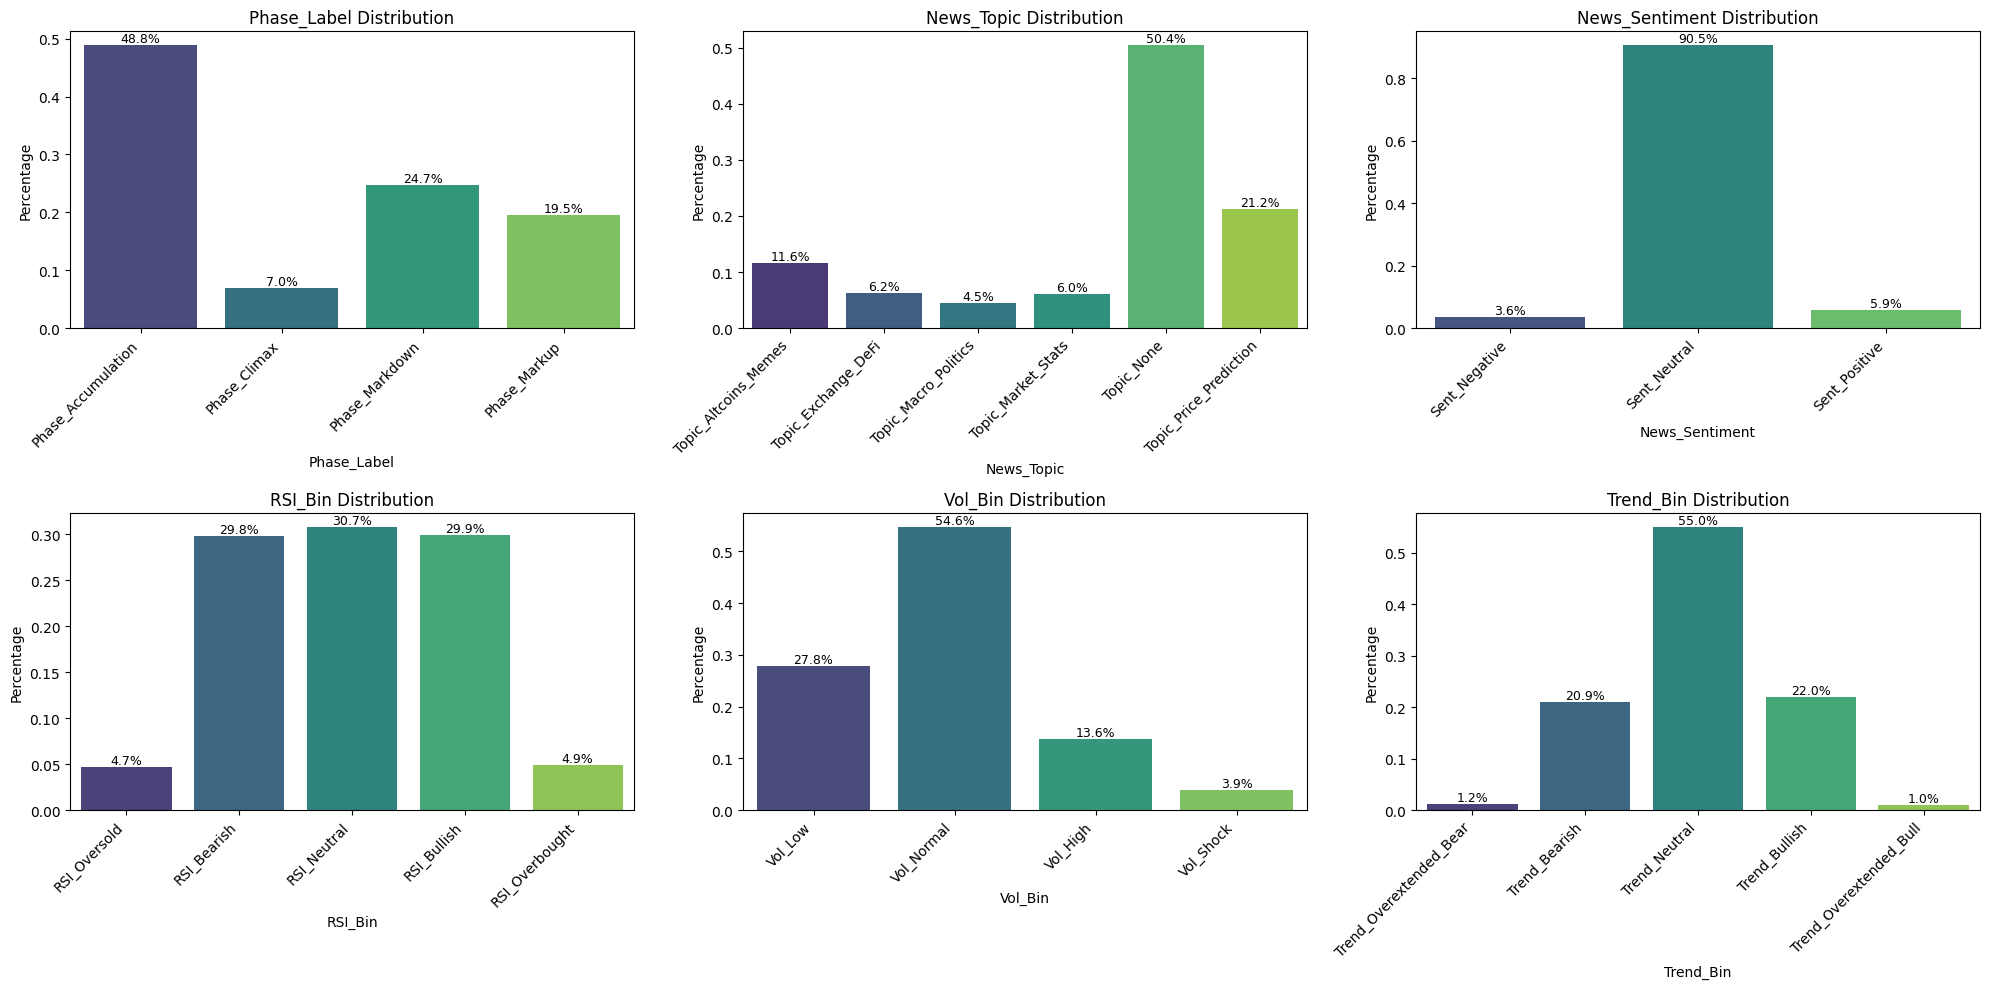

In [288]:
import warnings
warnings.filterwarnings("ignore")

print("Data Health Analysis for Integrated Test Set:")
analyze_data_health(integrated_df)

Data Health Analysis for Scored Test Set (without news features):
--- 1. DATA INTEGRITY CHECK ---
Total Rows: 489581
✅ No Missing Values found.

--- 2. NUMERICAL STATISTICS ---
             close   Bull_Score   Bear_Score   Net_Signal
count  489581.0000  489581.0000  489581.0000  489581.0000
mean   102579.4476       4.8137       4.8205      -0.0068
std     11567.2480       3.3698       3.5479       1.6871
min     74610.0000       0.0000       0.0000      -4.7291
25%     94240.4800       1.6783       1.6987      -1.0793
50%    104520.2800       4.1541       3.8111      -0.2532
75%    111559.9900       7.5444       7.7157       1.3280
max    126114.5000      12.3070      12.5917       4.0604


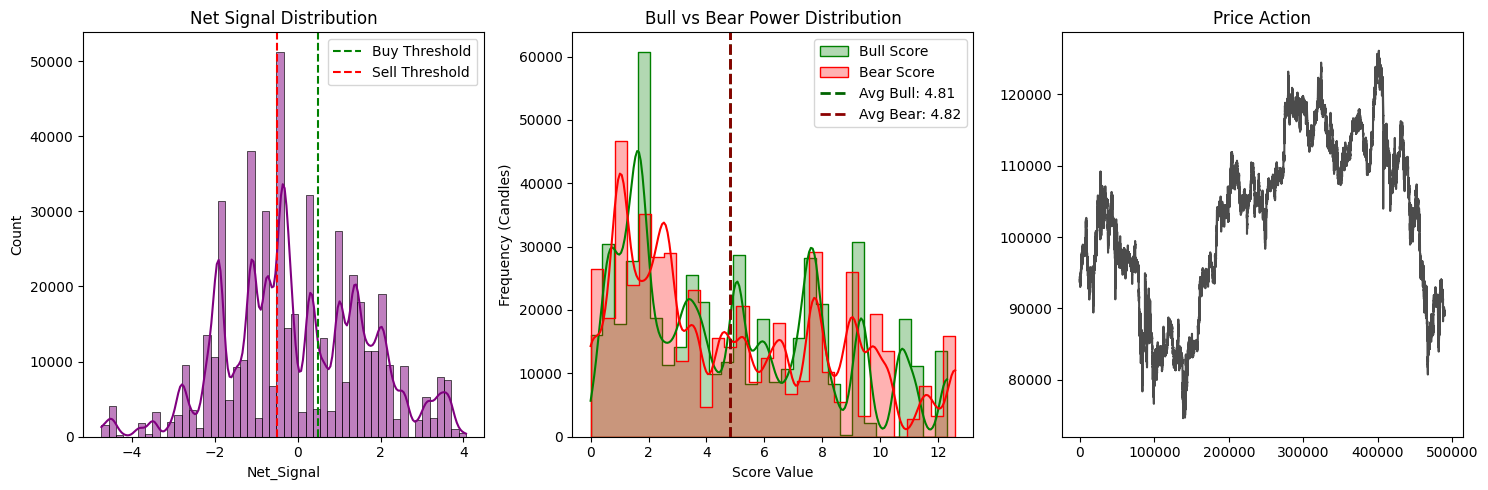

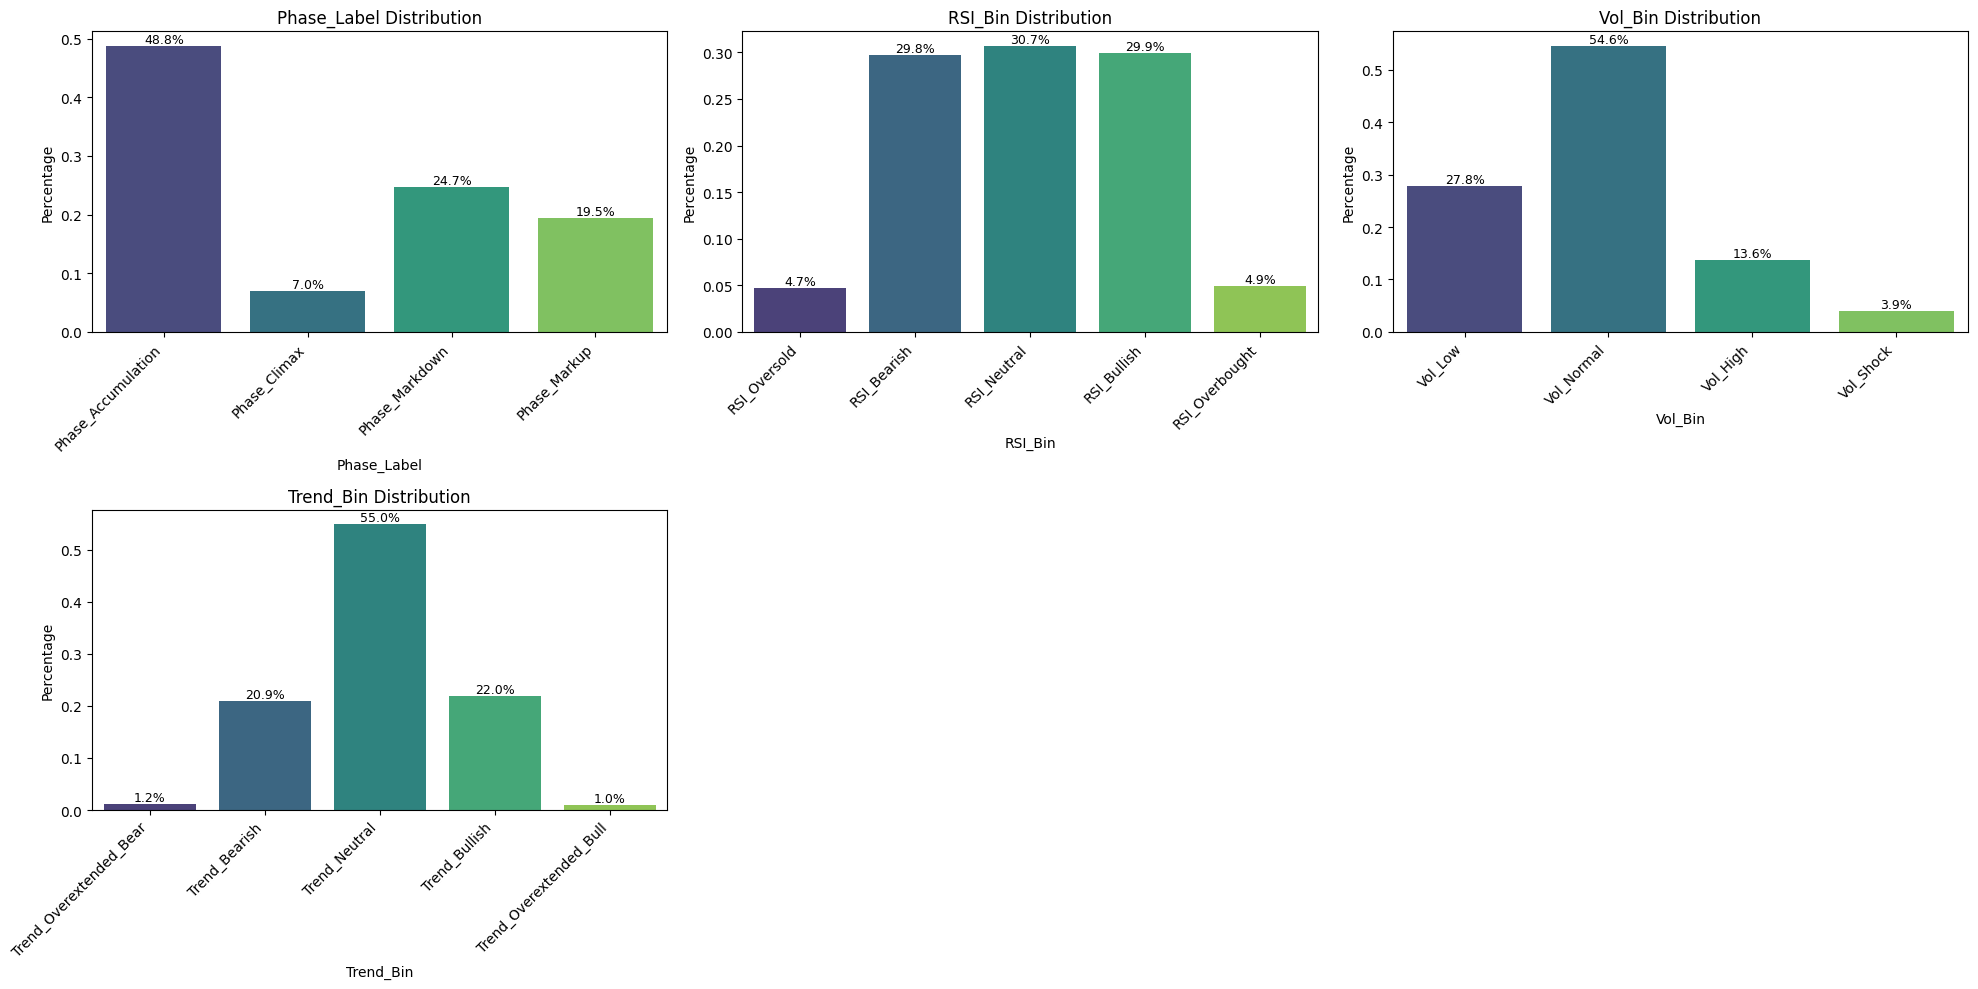

In [289]:
print("Data Health Analysis for Scored Test Set (without news features):")
analyze_data_health(df_scored)

### Backtest Engine Class

In [290]:
class BacktestEngine:
    def __init__(self, initial_capital=10000, fee_pct=0.001):
        self.initial_capital = initial_capital
        self.fee_pct = fee_pct

    def run_backtest(self, df, strategy_name="Strategy"):
        # Data preparation
        if "open_time" not in df.columns or "close" not in df.columns or "Action" not in df.columns:
            raise ValueError("DataFrame must contain 'open_time', 'close', and 'Action' columns.")
        data = df.copy().sort_values('open_time').reset_index(drop=True)
        
        # Drop rows with missing price data (fixes potential NaN issue from manual row insertion)
        data = data.dropna(subset=['close'])

        # State Variables 
        cash = self.initial_capital
        btc_balance = 0
        is_invested = False 

        # Tracking 
        portfolio_values = []
        trades = []

        for i, row in data.iterrows():
            price = row['close']
            action = row['Action']
            date = row['open_time']

            if is_invested:
                # We own BTC. Check for SELL signal
                if action == "SELL":
                    # sell 100% BTC
                    revenue = btc_balance * price 
                    fee = revenue * self.fee_pct 
                    cash = revenue - fee
                    btc_balance = 0 
                    is_invested = False 
                    trades.append({'date': date, 'type': 'SELL', 'price': price, 'value': cash})
            else: 
                # We have Cash. Check for BUY signal
                if action == 'BUY':
                    # Buy 100% BTC
                    fee = cash * self.fee_pct
                    net_cash = cash - fee 
                    btc_balance = net_cash / price 
                    cash = 0 
                    is_invested = True 
                    trades.append({'date': date, 'type': 'BUY', 'price': price, 'value': net_cash})
                
            if is_invested:
                current_val = btc_balance * price 
            else:
                current_val = cash
            
            portfolio_values.append(current_val)

        # Assign results AFTER the loop
        data['Portfolio_Value'] = portfolio_values 
        data['Strategy'] = strategy_name

        # Calculate final stats
        total_return = (portfolio_values[-1] - self.initial_capital) / self.initial_capital * 100

        return data, pd.DataFrame(trades), total_return
    
    def plot_results(self, results_dict):
        plt.figure(figsize=(15, 8))

        for name, df in results_dict.items():
            plt.plot(df['open_time'], df['Portfolio_Value'], label=f"{name} (End: ${df['Portfolio_Value'].iloc[-1]:,.0f})")
        
        plt.title(f'Strategy Comparison (Start: ${self.initial_capital:,.0f})')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


### Backtest Stimulation

In [357]:
def apply_trading_action(df, threshold_buy=5, threshold_sell=-5):
    """
    Creates the 'Action' column based on Net_Signal and Threshold.
    threshold=5 means:
      - Signal > 5  -> BUY
      - Signal < 5 -> SELL
      - Otherwise     -> HOLD
    """
    data = df.copy()
    
    # Define conditions
    conditions = [
        data['Net_Signal'] > threshold_buy,  # Conviction Buy
        data['Net_Signal'] < -threshold_sell  # Conviction Sell
    ]
    
    # Define results
    choices = ['BUY', 'SELL']
    
    # Apply logic (default to 'HOLD')
    data['Action'] = np.select(conditions, choices, default='HOLD')
    
    return data



# 1. Apply to Technical-Only Data
print("1. Setting Actions for Technical Strategy...")
df_scored = apply_trading_action(df_scored, threshold_sell=4.7, threshold_buy=4)
print(df_scored['Action'].value_counts())

# 2. Apply to Hybrid (News) Data
print("\n2. Setting Actions for Hybrid (News) Strategy...")
integrated_df = apply_trading_action(integrated_df, threshold_sell=6, threshold_buy=6)
print(integrated_df['Action'].value_counts())

1. Setting Actions for Technical Strategy...
Action
HOLD    487591
SELL      1576
BUY        414
Name: count, dtype: int64

2. Setting Actions for Hybrid (News) Strategy...
Action
HOLD    487747
BUY       1114
SELL       720
Name: count, dtype: int64


In [339]:
df_hodl = df_scored[['open_time', 'close']].copy()
df_hodl = df_hodl.reset_index(drop=True)
df_hodl['Action'] = 'HOLD'
df_hodl.loc[0, 'Action'] = 'BUY'

df_tech = df_scored.copy()

df_hybrid = integrated_df.copy()

In [340]:
df_tech['open_time']

19       2025-01-01 00:19:00
20       2025-01-01 00:20:00
21       2025-01-01 00:21:00
22       2025-01-01 00:22:00
23       2025-01-01 00:23:00
                 ...        
489595   2025-12-06 23:55:00
489596   2025-12-06 23:56:00
489597   2025-12-06 23:57:00
489598   2025-12-06 23:58:00
489599   2025-12-06 23:59:00
Name: open_time, Length: 489581, dtype: datetime64[ns]

STARTING BACKTEST SIMULATION...

STRATEGY             | RETURN     | TRADES     | FINAL VALUE
--------------------------------------------------
1. Buy & Hold        |  -4.87%   | 1          | $9,512.94
2. Technical Only    |   8.39%   | 361        | $10,838.53
3. AI Hybrid         |  13.44%   | 530        | $11,343.73

🏆 TOURNAMENT WINNER: Hybrid!


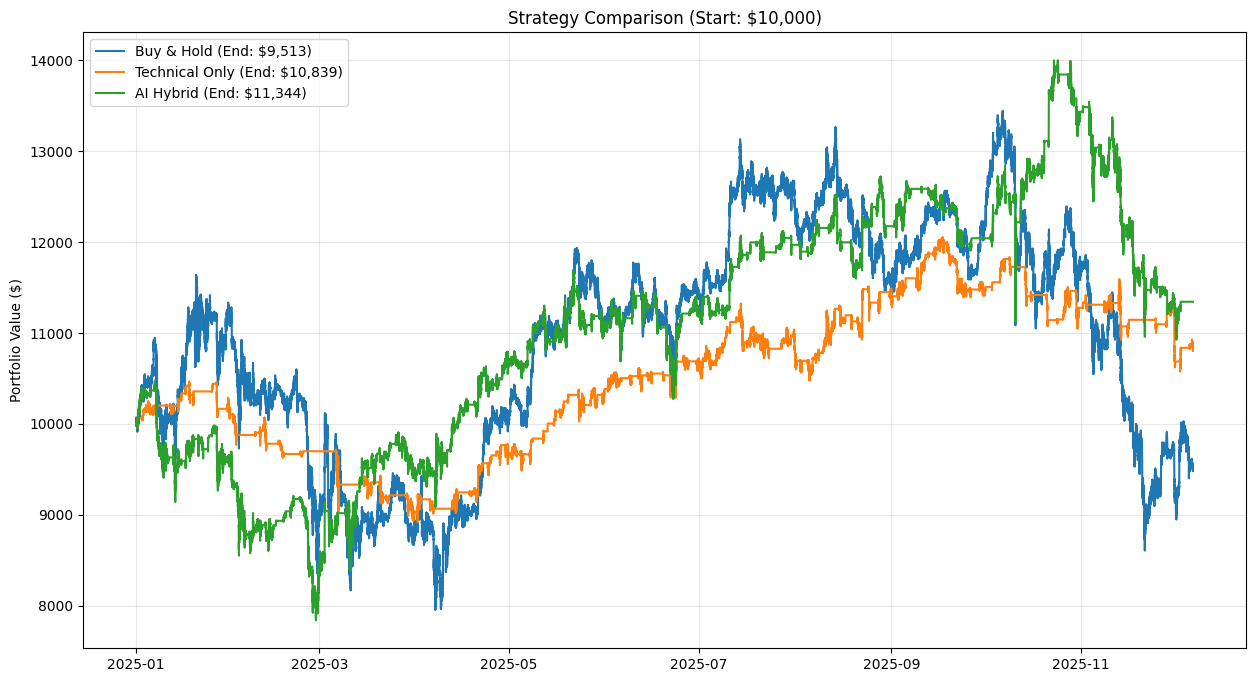

In [ ]:

# Re-initialize engine with fixed class
engine = BacktestEngine(initial_capital=10000, fee_pct=0.001)

print("STARTING BACKTEST SIMULATION...")

if 'open_time' not in df_hybrid.columns:
    df_hybrid = df_hybrid.reset_index()

if 'open_time' not in df_tech.columns:
    df_tech = df_tech.reset_index()

# Run Simulations
res_hodl, trades_hodl, ret_hodl = engine.run_backtest(df_hodl, "Buy & Hold")
res_tech, trades_tech, ret_tech = engine.run_backtest(df_tech, "Technical Only")
res_hybrid, trades_hybrid, ret_hybrid = engine.run_backtest(df_hybrid, "AI Hybrid")


# --- 4. THE PERFORMANCE REPORT ---
print("\n" + "="*50)
print(f"{'STRATEGY':<20} | {'RETURN':<10} | {'TRADES':<10} | {'FINAL VALUE'}")
print("-" * 50)
print(f"{'1. Buy & Hold':<20} | {ret_hodl:6.2f}%   | {len(trades_hodl):<10} | ${res_hodl['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"{'2. Technical Only':<20} | {ret_tech:6.2f}%   | {len(trades_tech):<10} | ${res_tech['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"{'3. AI Hybrid':<20} | {ret_hybrid:6.2f}%   | {len(trades_hybrid):<10} | ${res_hybrid['Portfolio_Value'].iloc[-1]:,.2f}")
print("="*50)

# Determine Winner
winner = max([('Buy & Hold', ret_hodl), ('Technical', ret_tech), ('Hybrid', ret_hybrid)], key=lambda x: x[1])
print(f"\n🏆 TOURNAMENT WINNER: {winner[0]}!")

# Plot Visuals
engine.plot_results({
    'Buy & Hold': res_hodl,
    'Technical Only': res_tech,
    'AI Hybrid': res_hybrid
})